# Lab 2

### Panoramic Stitching

In this portion of the lab, you will create a panoramic image by stitching together two images with overlapping features. First, time to take a small break from coding. Go visit one of your favorite spots on campus, and take two pictures of the spot. For the second picture, rotate slightly (about 30 degrees) from the position you took the first picture. The two photos should have some overlapping features so that we can construct a panorama.

Add your images to the code two cells below.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

<ipython-input-6-673b22027774>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  first_image = imageio.imread("IMG_2307.png") # Bc i have a left shift, the image with the leftmost view will be #1
<ipython-input-6-673b22027774>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  second_image = imageio.imread("IMG_2306.png") # Open your image here


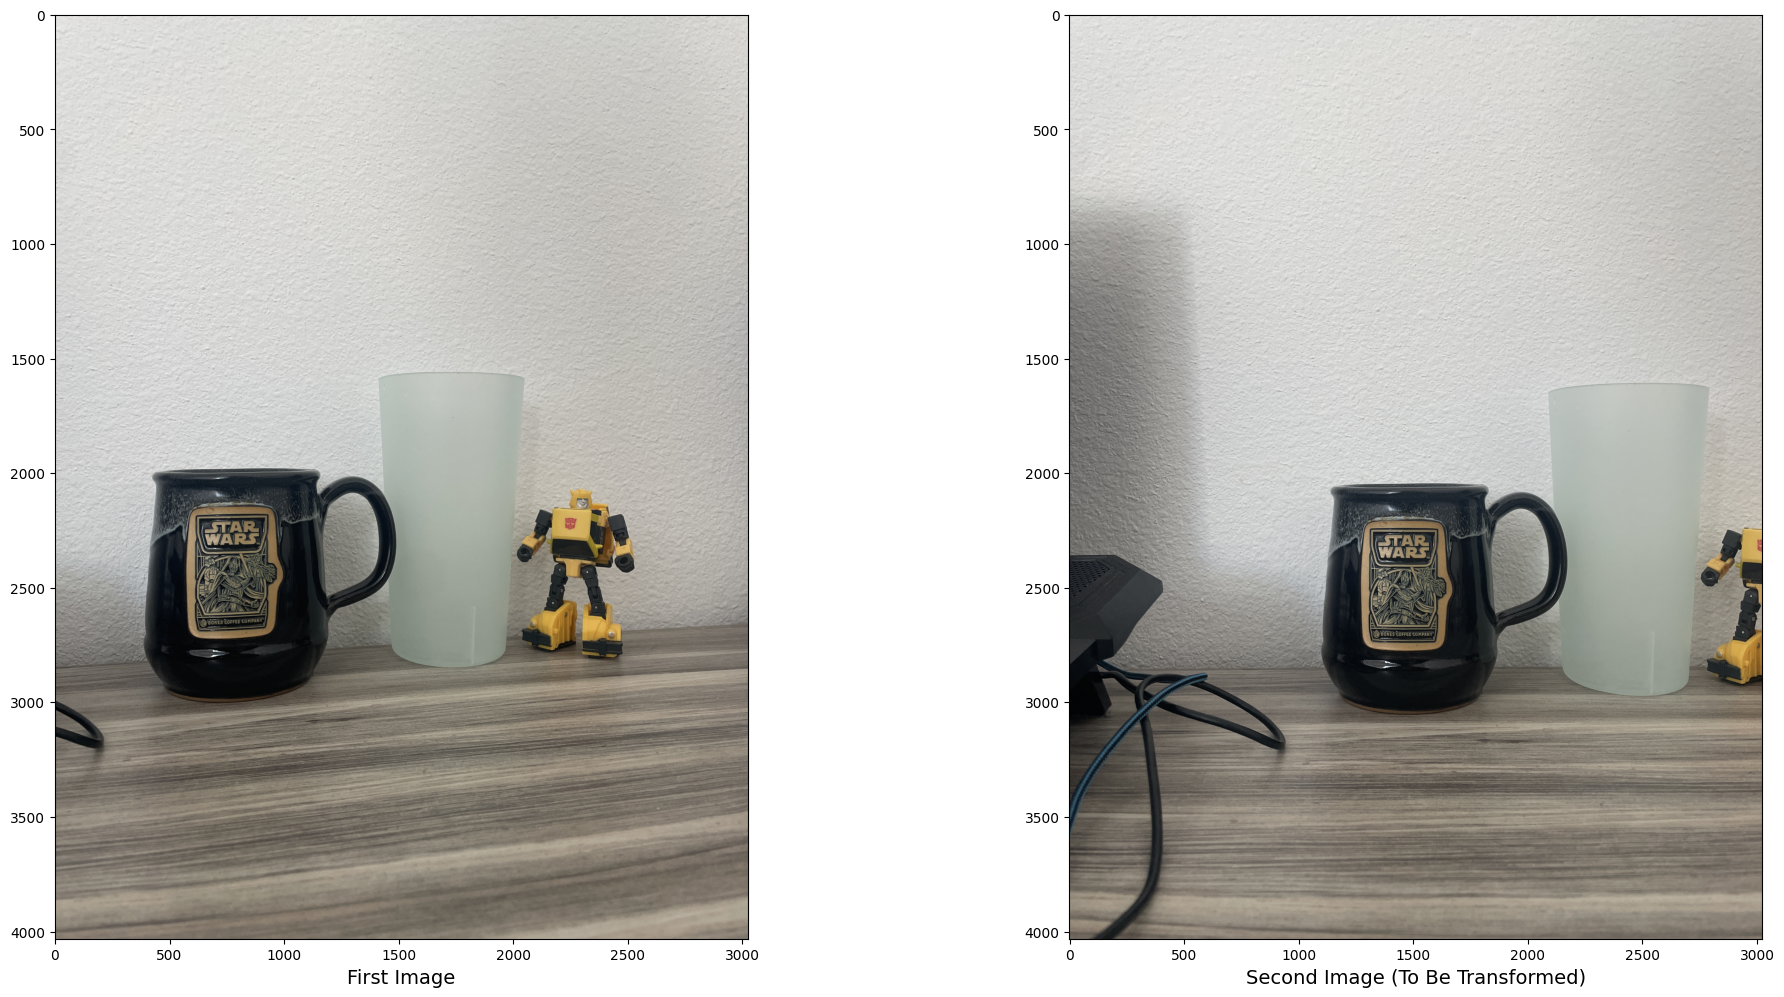

In [ ]:
# from google.colab import files
# uploaded = files.upload()

first_image = imageio.imread("IMG_2307.png") # Bc i have a left shift, the image with the leftmost view will be #1
second_image = imageio.imread("IMG_2306.png") # Open your image here

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,12))
ax1.imshow(first_image)
ax1.set_xlabel("First Image", fontsize=14)

ax2.imshow(second_image)
ax2.set_xlabel("Second Image (To Be Transformed)", fontsize=14)

plt.show()

First, we will use OpenCV to identify keypoints and a feature descriptor for each keypoint. We will use SIFT as our feature descriptor. *You can run these cells without modification.*

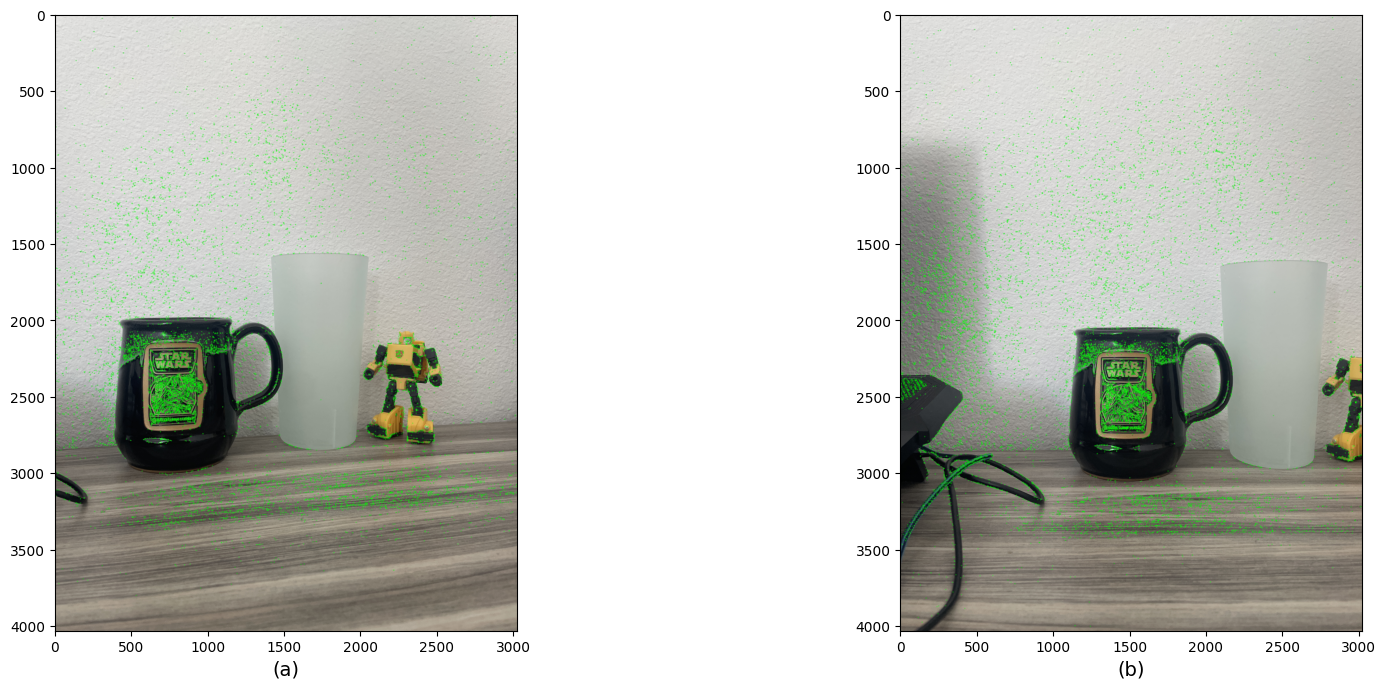

In [ ]:
def detectAndDescribe(image):
    """
    Compute key points and feature descriptors using SIFT
    """
    # detect and extract features from the image
    descriptor = cv2.xfeatures2d.SIFT_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)

    return (kps, features)

kpsA, featuresA = detectAndDescribe(first_image)
kpsB, featuresB = detectAndDescribe(second_image)

# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(first_image,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(second_image,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Next, we will match features between the two images, considering the features which are closest in distance to be a 'match'. *You can run these cells without modification.*

Raw matches (Brute force): 5738


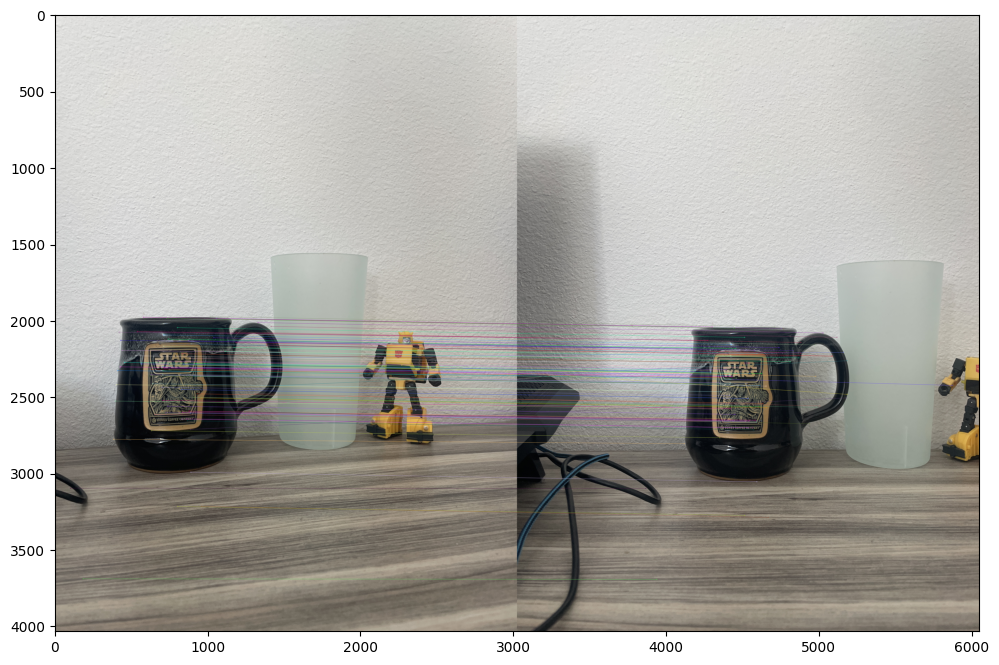

In [ ]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)

    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)

    # Sort the features in order of distance. The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

fig = plt.figure(figsize=(20,8))
matches = matchKeyPointsBF(featuresA, featuresB, method='sift')
match_image = cv2.drawMatches(first_image,kpsA,second_image,kpsB,matches[:100], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(match_image)
plt.show()

Now that we have the matches of our SIFT features between the first and second image (thanks to OpenCV), it's time to compute the homography between the two images. Your task is to find the best homography matrix given your matches. We will do this using the RANSAC algorithm. For each iteration of RANSAC, you will sample 4 points (the minimum required to estimate a homography matrix), and use the direct linear transform (DLT) to estimate the homography matrix. Based on the RANSAC algorithm, you will iterate over multiple groupings of four points, saving the best-fitting model at the end of all RANSAC iterations.

In [ ]:
import numpy as np
import random

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # Convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    # Ensure that there are enough matches to compute the homography
    if len(matches) >= 4:

        # Extract the matched points from the keypoints
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # [TASK] Implement RANSAC to compute the homography matrix
        # 1. Randomly select 4 pairs of points from the matches.
        # 2. Use these 4 points to compute a candidate homography.
        # 3. Calculate the error for each match.
        # 4. Count how many matches are inliers (error <= threshold).
        # 5. Repeat steps 1-4 for a set number of iterations.
        # 6. Return the homography with the maximum number of inliers.

        # RANSAC Parameters
        iterations = 1000  # Maximum number of iterations
        best_inliers = 0
        best_H = None
        best_status = None # Status is a boolean value, represented by an integer 0 or 1, which represents whether the reprojection error is under the threshold.

        # [TASK] Your RANSAC loop begins here
        for i in range(iterations):
            s = random.sample(range(len(matches)), 4)  # getting 4 random samples from matches

            selected_ptsA = np.float32([ptsA[idx] for idx in s])
            selected_ptsB = np.float32([ptsB[idx] for idx in s])

            H_candidate = computeHomography(selected_ptsA, selected_ptsB)  # fitting the random samples to the homography model
            errors = calculateTransferError(ptsA, ptsB, H_candidate)  # calculating the errors per each point
            status = errors < reprojThresh  # boolean mask for the errors
            num_inliers = np.sum(status) # counting the amount of inliers per iteration

            if num_inliers > best_inliers:
                best_inliers = num_inliers
                best_H = H_candidate # store the homography matrix
                best_status = status

        # returning the matches and best homography matrix
        return (matches, best_H, best_status)

    else:
        return None


def computeHomography(ptsA, ptsB):
    # assuming that ptsA represents the X_s part of A
    # therefore, ptsB is the X_d part of A
    A = [] # initializing it as an array

    for i in range(4): # 4 is the minimum s required for homography
      x_d, y_d = ptsB[i] # the destination image points
      x_s, y_s = ptsA[i] # the source image points

      A.append([x_s, y_s, 1, 0, 0, 0, -x_d * x_s, -x_d * y_s, -x_d])
      A.append([0, 0, 0, x_s, y_s, 1, -y_d * x_s, -y_d * y_s, -y_d])

    new_A = np.array(A) # now converting it to a numpy array

    # now going to apply the singular value decomposition
    # using the method from the lecture slides
    U, S, Vt = np.linalg.svd(new_A) # U = mxn matrix containing left singular values
    # S = Sigma = mxn diagonal matrix with singular values
    # Vt is V transpose of right singular vectors

    # the smallest singular value is the last element of S
    sigma_min = S[-1]
    # now, we just have to find the eigenvector that that sigma value corresponds to

    # The corresponding eigenvector is the last column of Vt
    eigenvector = Vt[-1, :].reshape((3,3)).astype(np.float32)

    return eigenvector


def calculateTransferError(ptsA, ptsB, H):
  # assuming ptsA is the source image vector
  # assuming that ptsB is the destination image vector

  # converting the points to homogeneous coordinates
  source_homogeneous = np.hstack((ptsA, np.ones((ptsA.shape[0], 1))))
  destination_homogeneous = np.hstack((ptsB, np.ones((ptsB.shape[0], 1))))

  inverse_h = np.linalg.inv(H) # taking inverse of the homography matrix for the transfer error equation

  total_transfer_error = []# this is going to be the sum of the squared errors

  for i in range(len(ptsA)):
    # now doing the forward transformation
    source_x = source_homogeneous[i]
    dest_x_prediction = np.dot(H, source_x.T) # getting the destination prediction
    dest_x_prediction /= dest_x_prediction[2] #converting back to homogeneous coordinates

    # now doing the inverse transforamtion
    destination_x = destination_homogeneous[i]
    source_x_pred = np.dot(inverse_h, destination_x.T)
    source_x_pred /= source_x_pred[2]

    # now going to do the forward error and inverse error calculations

    forward_error = np.sqrt(np.sum((ptsB[i] - dest_x_prediction[:2]) ** 2))
    inverse_error = np.sqrt(np.sum((ptsA[i] - source_x_pred[:2]) ** 2))

    total_transfer_error.append(forward_error + inverse_error)

  return np.array(total_transfer_error)

Run the following cell to check if we got the homography correct by seeing how the panorama looks. Note that there are many complex variations of this algorithm; for example, variants of RANSAC and coordinate normalization techniques help ensure robustness to outliers and numerical stability of DLT solutions. It is ok if your stiching is not perfect, as long as your base algorithm is implemented correctly.

[[ 9.3477470e-04 -2.1904920e-05  9.5347106e-01]
 [-1.6574387e-04  1.0659904e-03  3.0147871e-01]
 [-8.3521037e-08 -1.2138821e-08  1.2053283e-03]]


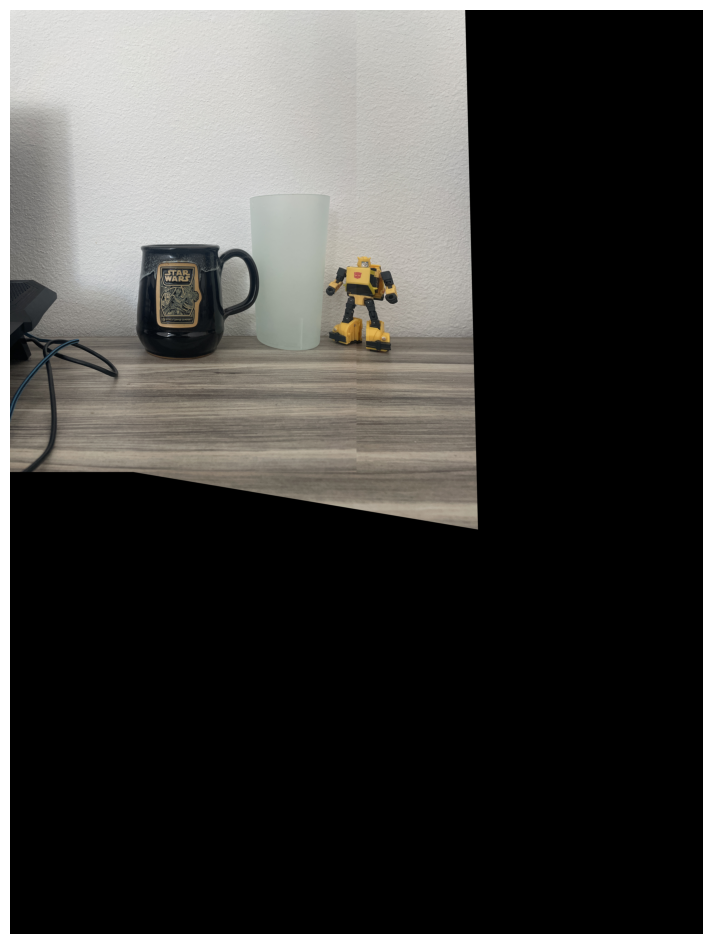

In [ ]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

# Apply panorama correction
width = first_image.shape[1] + second_image.shape[1]
height = first_image.shape[0] + second_image.shape[0]

result = cv2.warpPerspective(first_image, H, (width, height))
result[0:second_image.shape[0], 0:second_image.shape[1]] = second_image

plt.figure(figsize=(24,12))
plt.imshow(result)
plt.axis('off')
plt.show()

Congratulations on completing Lab 2! Please turn in your PDF report and .ipynb to Gradescope.